# **1. Extracting BERT Embeddings**

## 1.1 Method 1



In [ ]:
!pip install transformers

     |████████████████████████████████| 2.9 MB 5.1 MB/s 
     |████████████████████████████████| 636 kB 60.4 MB/s 
     |████████████████████████████████| 56 kB 4.2 MB/s 
     |████████████████████████████████| 3.3 MB 43.0 MB/s 
     |████████████████████████████████| 895 kB 47.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
# IMPORTS 
from transformers import BertTokenizer, BertModel
import torch 
from sklearn.decomposition import PCA

### **1.2.1 Initiate BERT**

In [ ]:
# data pretrained on: https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-vocab.txt


# to use own pretrained model: 
# Model was saved using `save_pretrained('./test/saved_model/')` (for example purposes, not runnable).
# model = BertModel.from_pretrained('./test/saved_model/')

PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

bert_embeddings = bert_model.get_input_embeddings()

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### **1.2.2 Get the data**

In [ ]:
# mounting google drive
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!cp "/content/gdrive/MyDrive/Colab Notebooks/train.csv" "/content/train.csv"

In [ ]:
import pandas as pd
train = pd.read_csv('/content/train.csv')
train.tail(3)

,id,text,author
19576,id05267,"Mais il faut agir that is to say, a Frenchman ...",EAP
19577,id17513,"For an item of news like this, it strikes us i...",EAP
19578,id00393,"He laid a gnarled claw on my shoulder, and it ...",HPL


### **1.2.3 Format the data**

In [ ]:
train['word_ids'] = train['text'].apply(lambda x: tokenizer.convert_tokens_to_ids(tokenizer.tokenize(x)))

In [ ]:
train.head(1)

,id,text,author,word_ids
0,id26305,"This process, however, afforded me no means of...",EAP,"[1188, 1965, 117, 1649, 117, 25520, 1143, 1185..."


In [ ]:
def count_words(df):
    cols = ['count']
    word_count = pd.DataFrame(df['text'].str.split(expand=True).stack().value_counts(), columns=cols)
    word_count.reset_index(level=0, inplace=True)
    word_count.columns = ['word', 'count']
    return word_count

word_count = count_words(train)
word_count

,word,count
0,the,33296
1,of,20851
2,and,17059
3,to,12615
4,I,10382
...,...,...
47551,"erroneous,",1
47552,talking;,1
47553,traipsin',1
47554,L's,1


### **1.2.4 Functions for Extracting Embeddings**

use the BERT pre-trained embeddings which map each word id to its (1,768) vector.

helper functions in order to extract the word id for each token, and the embedding vector for each word id:

In [ ]:
def word_to_index(word):
    token_id = tokenizer.convert_tokens_to_ids(word)
    return token_id

def indices_to_vec(word_ids):
    embeded_tokens = bert_embeddings(torch.Tensor(word_ids).to(torch.long))
    return embeded_tokens.detach().numpy()


def index_to_vec(word_id):
    embeded_token = bert_embeddings(torch.Tensor([word_id]).to(torch.long))
    return embeded_token.detach().numpy()


In [ ]:
# THIS WAS FROM BEFORE - NEED ONE LONG STRING OF GENDER WORDS (NOT A LIST LIKE BELOW)

# # generate word ids for the words pairs

gender_pairs = "she he her his woman man aunt uncle niece nephew daugters sons mother father daughter son grandaughter grandson girl boy stepdaughter stepson mom dad"

word_ids = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(gender_pairs))
print(word_ids)


[1131, 1119, 1123, 1117, 1590, 1299, 8524, 4906, 12585, 7502, 5358, 9610, 5759, 3824, 1534, 1401, 1797, 1488, 5372, 23825, 2083, 7254, 1873, 2298, 2585, 1810, 26760, 3343, 1320, 4113, 4153]


In [ ]:
gender_pairs = ["she", "he", "her", "his", "woman", "man", "aunt", "uncle", "niece", "nephew", "daugters", "sons", "mother", "father", "daughter", "son", "grandaughter", "grandson", "girl", "boy", "stepdaughter", "stepson", "mom","dad"]

In [ ]:
import pandas as pd
cols = ['word', 'word_id']
df_for_pca = pd.DataFrame(zip(gender_pairs, word_ids), columns = cols)
df_for_pca

,word,word_id
0,she,1131
1,he,1119
2,her,1123
3,his,1117
4,woman,1590
5,man,1299
6,aunt,8524
7,uncle,4906
8,niece,12585
9,nephew,7502


In [ ]:
df_for_pca['word_vec'] = df_for_pca['word_id'].apply(index_to_vec)
df_for_pca.head()

,word,word_id,word_vec
0,she,1131,"[[-0.03390125, 0.019389033, 0.0010120879, 0.01..."
1,he,1119,"[[-0.0002244141, 0.024620801, -0.010688784, 0...."
2,her,1123,"[[0.004219352, 0.029523268, -0.04063679, -0.03..."
3,his,1117,"[[0.019576656, 0.037966713, -0.033559605, -0.0..."
4,woman,1590,"[[0.031037057, -0.02565798, 0.02183031, 0.0227..."


In [ ]:
df_for_pca['word_xy'] = df_for_pca['word_vec'].apply(vec_to_2dim)
df_for_pca['word_x'] = df_for_pca['word_xy'].apply(tuple_x)
df_for_pca['word_y'] = df_for_pca['word_xy'].apply(tuple_y)
df_for_pca

,word,word_id,word_vec,word_xy,word_x,word_y
0,she,1131,"[[-0.03390125, 0.019389033, 0.0010120879, 0.01...","(0.7624802, 0.42542326)",0.762480,0.425423
1,he,1119,"[[-0.0002244141, 0.024620801, -0.010688784, 0....","(0.74066085, 0.50901234)",0.740661,0.509012
2,her,1123,"[[0.004219352, 0.029523268, -0.04063679, -0.03...","(0.7477989, 0.54219943)",0.747799,0.542199
3,his,1117,"[[0.019576656, 0.037966713, -0.033559605, -0.0...","(0.744513, 0.544316)",0.744513,0.544316
4,woman,1590,"[[0.031037057, -0.02565798, 0.02183031, 0.0227...","(0.8114155, 0.4185461)",0.811415,0.418546
5,man,1299,"[[0.03547242, -0.009771521, 0.023980722, -0.02...","(0.7699941, 0.58617055)",0.769994,0.586171
6,aunt,8524,"[[-0.031035986, -0.018487606, 0.02495961, 0.00...","(0.97072226, -0.009598386)",0.970722,-0.009598
7,uncle,4906,"[[0.06393534, 0.02730004, -0.016631322, -0.019...","(0.9125542, 0.092042945)",0.912554,0.092043
8,niece,12585,"[[0.056558516, 0.00379794, 0.05723976, -0.0003...","(1.0055737, -0.10458182)",1.005574,-0.104582
9,nephew,7502,"[[0.04509845, 0.030363822, 0.041744396, -0.040...","(0.958157, -0.014693392)",0.958157,-0.014693


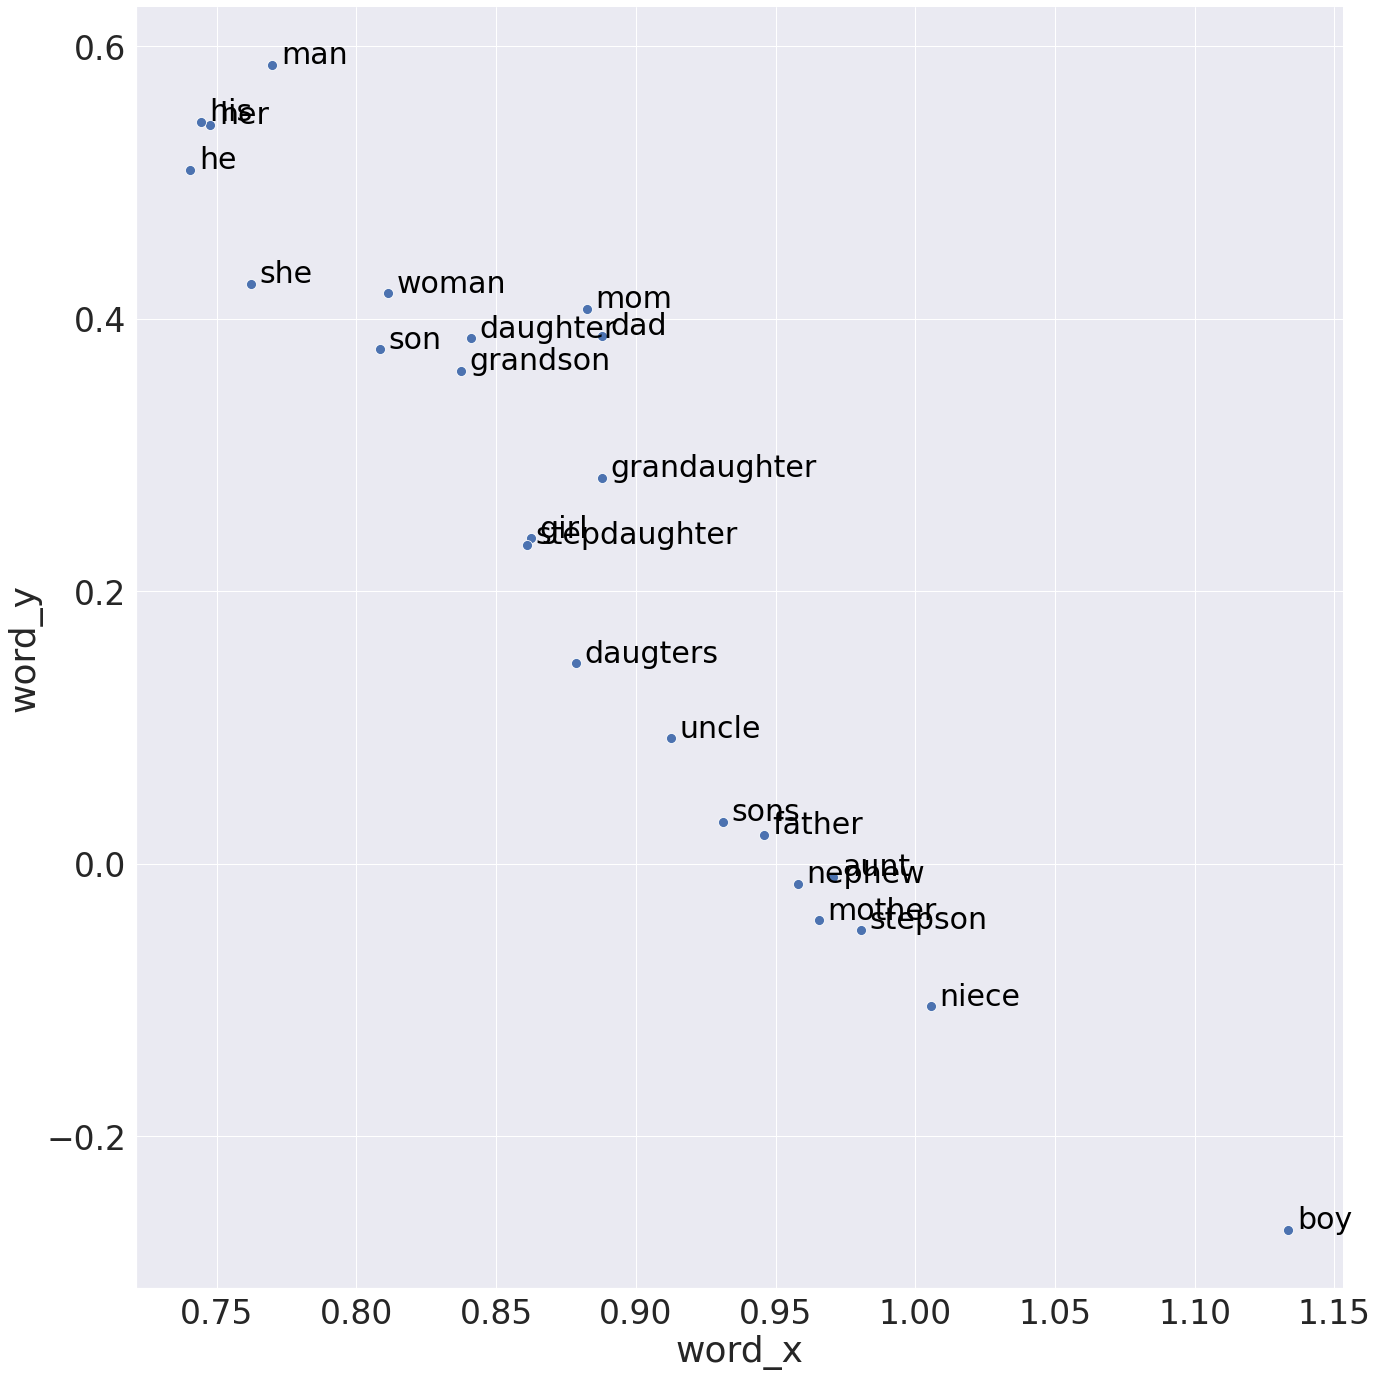

In [ ]:
# plot
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 140)

sns.set(rc = {'figure.figsize':(10,5)}, font_scale=3)

p = sns.relplot(x="word_x", y="word_y",
             alpha=1, palette="muted",
            height=20, s=100, label = 'big', aspect=1, data=df_for_pca)
ax = p.axes[0,0]

for idx, row in df_for_pca.iterrows():
     ax.text(row['word_x']+ 0.003, row['word_y']+0.001, row['word'], horizontalalignment='left', size='small', color='black')

trying with larger data

1. individual words
2. keeping them as sentences 

In [ ]:
# extracting the embeddings
word_count['word_id'] = word_count['word'].apply(word_to_index)
vectors = index_to_vec(word_count['word_id'].to_numpy())
pca = PCA(n_components=2)
pca.fit(vectors.squeeze())
word_count['word_vec'] = word_count['word_id'].apply(index_to_vec)
word_count.head()

,word,count,word_id,word_vec
0,the,33296,1103,"[[-0.04128282, 0.028885774, -0.041111287, 0.02..."
1,of,20851,1104,"[[-0.018423943, 0.028360885, 0.003914881, -0.0..."
2,and,17059,1105,"[[-0.027223332, 0.01628675, -0.008561882, -0.0..."
3,to,12615,1106,"[[0.038330674, 0.015045563, -0.004117922, 0.02..."
4,I,10382,146,"[[-0.030673549, 0.011712232, 0.038565163, 0.01..."


In [ ]:
#word_count["word_vec"] = word_count.word_vec.astype(np.float)
word_count.dtypes

In [ ]:
embedding_list = word_count.word_vec.tolist()
assert(len(embedding_list[0]) == len(embedding_list[200]))
gender1 = embedding_list[0] - embedding_list[1]
for l in gender1: 
  print(len(l))

768


Apply the functions and fit the **PCA** for our data

In [ ]:
# Apply PCA 

word_count['word_id'] = word_count['word'].apply(word_to_index)
vectors = index_to_vec(word_count['word_id'].to_numpy())
pca = PCA(n_components=2)
pca.fit(vectors.squeeze())
# word_vec column is the embedding
word_count['word_vec'] = word_count['word_id'].apply(index_to_vec)

vectors.shape

(1, 47556, 768)

reduce the dimension to 2

In [ ]:
# functions needed for PCA
def vec_to_2dim(word_vec):
    xy = list(pca.transform(word_vec))
    xy = xy[0][0], xy[0][1]
    return xy

def tuple_x(xy):
    return tuple(xy)[0]

def tuple_y(xy):
    return tuple(xy)[1]


In [ ]:
# reduce to 2 dimensions and add to dataframe 
word_count['word_xy'] = word_count['word_vec'].apply(vec_to_2dim)
word_count['word_x'] = word_count['word_xy'].apply(tuple_x)
word_count['word_y'] = word_count['word_xy'].apply(tuple_y)
word_count

,word,count,word_id,word_vec,word_xy,word_x,word_y
0,the,33296,1103,"[[-0.04128282, 0.028885774, -0.041111287, 0.02...","(0.67844427, 0.6647572)",0.678444,0.664757
1,of,20851,1104,"[[-0.018423943, 0.028360885, 0.003914881, -0.0...","(0.69378495, 0.634493)",0.693785,0.634493
2,and,17059,1105,"[[-0.027223332, 0.01628675, -0.008561882, -0.0...","(0.67557484, 0.7126182)",0.675575,0.712618
3,to,12615,1106,"[[0.038330674, 0.015045563, -0.004117922, 0.02...","(0.7266493, 0.64040554)",0.726649,0.640406
4,I,10382,146,"[[-0.030673549, 0.011712232, 0.038565163, 0.01...","(0.7019248, 0.5289081)",0.701925,0.528908
...,...,...,...,...,...,...,...
47551,"erroneous,",1,100,"[[-0.06084983, -0.026864681, -0.044703305, 0.0...","(-0.26462844, -0.0025529005)",-0.264628,-0.002553
47552,talking;,1,100,"[[-0.06084983, -0.026864681, -0.044703305, 0.0...","(-0.26462844, -0.0025529005)",-0.264628,-0.002553
47553,traipsin',1,100,"[[-0.06084983, -0.026864681, -0.044703305, 0.0...","(-0.26462844, -0.0025529005)",-0.264628,-0.002553
47554,L's,1,100,"[[-0.06084983, -0.026864681, -0.044703305, 0.0...","(-0.26462844, -0.0025529005)",-0.264628,-0.002553


### **1.2.5 Finding the Gender Direction**

In [ ]:
# gender pair words: 

gender_pairs = ["she", "he", "her", "his", "woman", "man", "aunt", "uncle", "niece", "nephew", "daugters", "sons", "mother", "father", "daughter", "son", "grandaughter", "grandson", "girl", "boy", "stepdaughter", "stepson", "mom","dad"]

In [ ]:
# Searching in whole column for gender words
for i in range(len(word_count.word)):
    if 'she' == word_count.word[i]:
          
        # indx will store the tuple having that 
        # particular value in column.
        indx = i
  
# below line will print that tuple
word_count.iloc[indx]

word                                                                                                                                                she
count                                                                                                                                               957
word_id                                                                                                                                            1131
word_vec    [[-0.03390125, 0.019389033, 0.0010120879, 0.016935691, 0.007077763, -0.037435383, -0.0336617, -0.029336803, 0.043541253, 0.03215376, -0....
word_xy                                                                                                                         (0.7624802, 0.42542326)
word_x                                                                                                                                          0.76248
word_y                                                                                  

In [ ]:
df_list = [] 
for g in gender_pairs:
    df = pd.DataFrame(word_count.loc[word_count['word'] == g])
    df_list.append(df)

df = pd.concat(df_list, ignore_index = True)
df

# need to remove grandson and sons as they are not in a gender pair!
df = df[df.word != 'sons']
df = df[df.word != 'grandson']

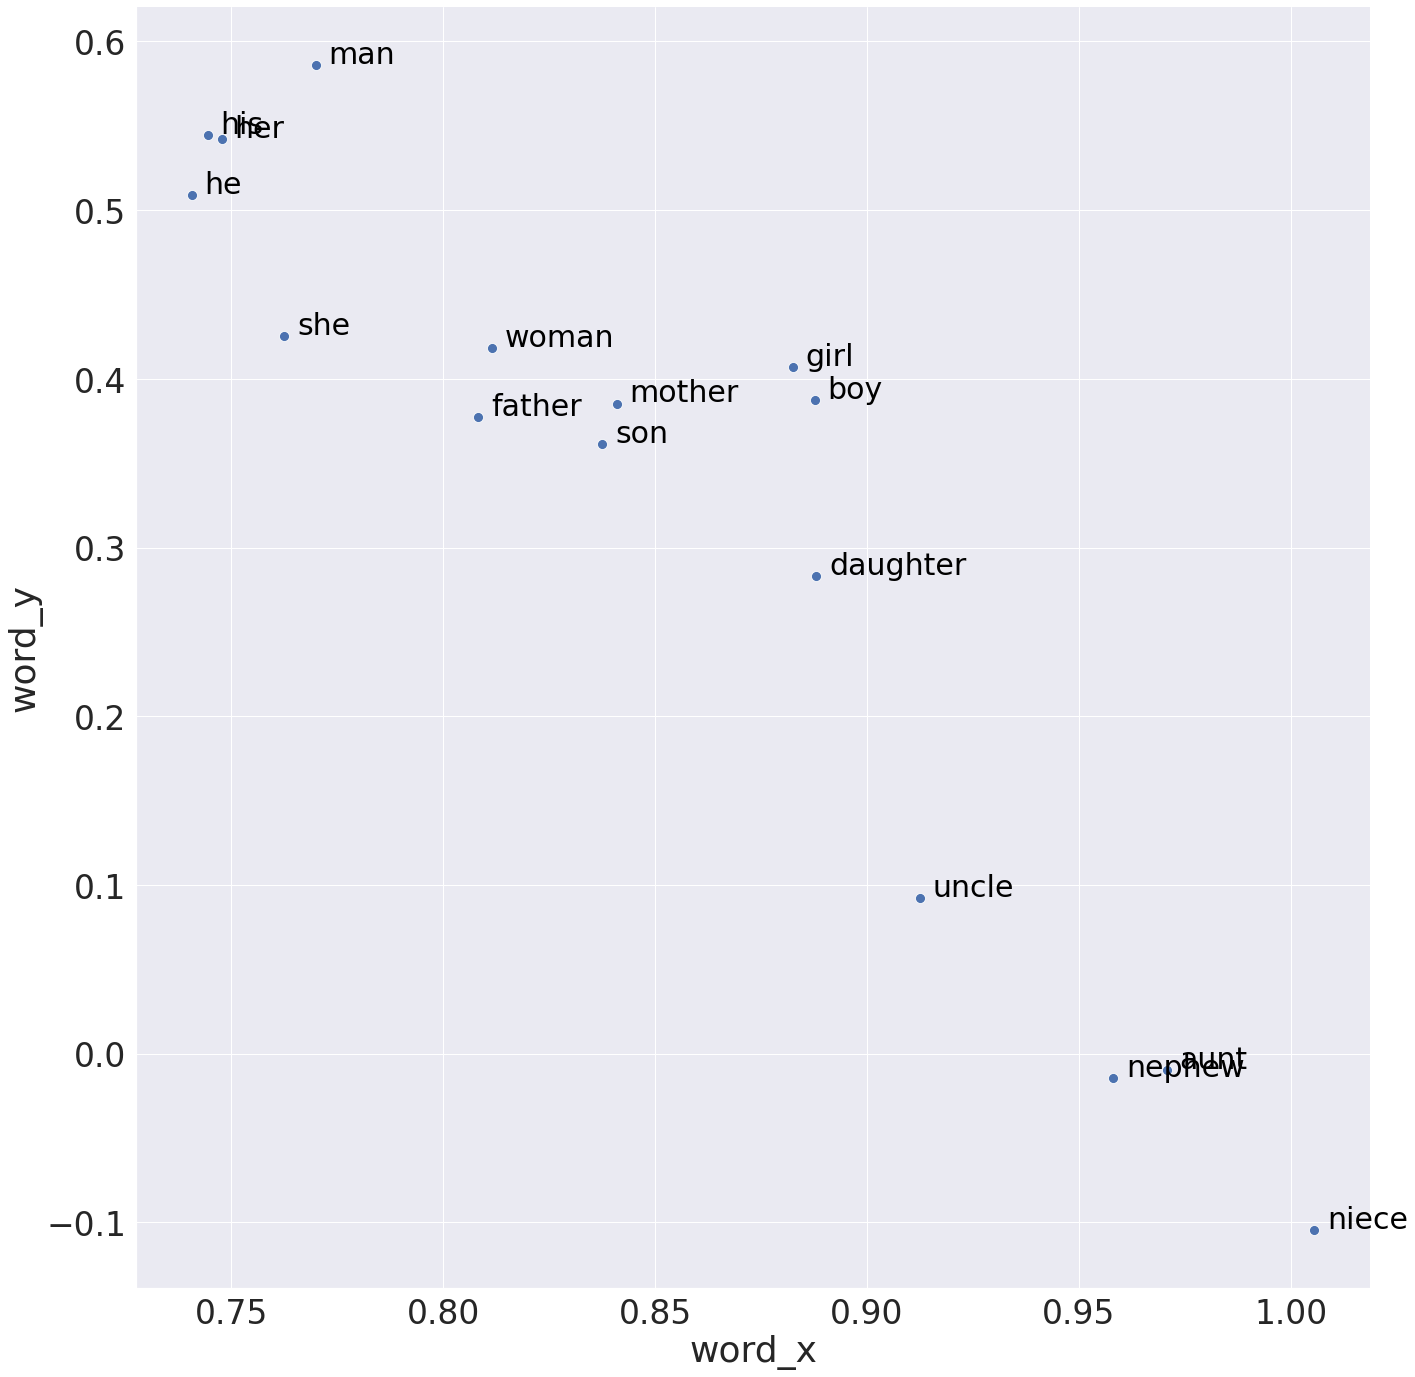

In [ ]:
# plot
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 140)

sns.set(rc = {'figure.figsize':(10,5)}, font_scale=3)

p = sns.relplot(x="word_x", y="word_y",
             alpha=1, palette="muted",
            height=20, s=100, label = 'big', aspect=1, data=df)
ax = p.axes[0,0]

for idx, row in df.iterrows():
     ax.text(row['word_x']+ 0.003, row['word_y']+0.001, row['word'], horizontalalignment='left', size='small', color='black')

In [ ]:
# pairs = [
#     ("woman", "man"),
#     ("her", "his"),
#     ("she", "he"),
#     ("aunt", "uncle"),
#     ("niece", "nephew"),
#     ("daughters", "sons"),
#     ("mother", "father"),
#     ("daughter", "son"),
#     ("granddaughter", "grandson"),
#     ("girl", "boy"),
#     ("stepdaughter", "stepson"),
#     ("mom", "dad"),
# ]


In [ ]:
# FUNCTION FOR GENDER DIRECTION WHEN USING XY COORDS

# import numpy as np
# def _np_normalize(v):
#   """Returns the input vector, normalized."""
#   return v / np.linalg.norm(v)

# def find_gender_direction(embed_df):
#   """Finds and returns a 'gender direction'.
  
#   Args:
#   - embed: the embedding matrix 
#   - indices: a dictionary mapping from string to their corresponding indixes in the embedding matrix
#   """
#   l = embed_df['word_xy'].tolist()
#   a = np.array(l)

#   m = []
#   for i in range(1,len(df)):
#     m.append(a[i] - a[i-1])
#   m = np.array(m)
#  # the next three lines are just a PCA.
#   m = np.cov(np.array(m).T)
#   evals, evecs = np.linalg.eig(m)
#   return _np_normalize(np.real(evecs[:, np.argmax(evals)])) 

In [ ]:
# # Using the embeddings, find the gender vector.
# gender_direction = find_gender_direction(df)
# print("gender direction: {}".format(str(gender_direction.flatten())))

In [ ]:
# FINDING GENDER DIRECTION USING ORIGINAL EMBEDDINGS 

gend_emb_list = df.word_vec.tolist() 
gender1 = (gend_emb_list[0] - gend_emb_list[1])
gender2 = gend_emb_list[2] - gend_emb_list[3]
gender3 = gend_emb_list[4] - gend_emb_list[5]
gender4 = gend_emb_list[6] - gend_emb_list[7]
gender5 = gend_emb_list[8] - gend_emb_list[9]
gender6 = gend_emb_list[10] - gend_emb_list[11]
gender7 = gend_emb_list[12] - gend_emb_list[13]
gender8 = gend_emb_list[14] - gend_emb_list[15]


a = np.append(gender1, gender2)
b = np.append(a, gender3)
c = np.append(b, gender4)
d = np.append(c, gender5)
e = np.append(d, gender6)
f = np.append(e, gender7)
gender_dir_all = np.append(f, gender8)


In [ ]:
from itertools import chain

gend_emb_list = df.word_vec.tolist() 
gender1 = (gend_emb_list[0] - gend_emb_list[1]).tolist()
gender1 = list(chain.from_iterable(gender1))

gender2 = (gend_emb_list[2] - gend_emb_list[3]).tolist()
gender2 = list(chain.from_iterable(gender2))

gender3 = (gend_emb_list[4] - gend_emb_list[5]).tolist()
gender3 = list(chain.from_iterable(gender3))

gender4 = (gend_emb_list[6] - gend_emb_list[7]).tolist()
gender4 = list(chain.from_iterable(gender4))

gender5 = (gend_emb_list[8] - gend_emb_list[9]).tolist()
gender5 = list(chain.from_iterable(gender5))

gender6 = (gend_emb_list[10] - gend_emb_list[11]).tolist()
gender6 = list(chain.from_iterable(gender6))

gender7 = (gend_emb_list[12] - gend_emb_list[13]).tolist()
gender7 = list(chain.from_iterable(gender7))

gender8 = (gend_emb_list[14] - gend_emb_list[15]).tolist()
gender8 = list(chain.from_iterable(gender8))


m = [gender1, gender2, gender3, gender4, gender5, gender6, gender7, gender8]

m = np.array(m)
print(type(m))

In [ ]:
def find_gend_dir(m):
  m = np.cov(np.array(m).T)
  evals, evecs = np.linalg.eig(m)
  return _np_normalize(np.real(evecs[:, np.argmax(evals)])) 

In [ ]:
gend_dir = find_gend_dir(m)
print(len(gend_dir))

### **1.2.6 Computing Z (finding biased words)**

finding the gender direction of certain words. 

this is needed for computing Z from X. 

times the embedding vector for the word with the gender direction (the dot product) 

this finds the projection of words onto the gender dimension. 

"Once you have the first principal component of the embedding differences, you can start projecting the embeddings of words onto it.  That projection is roughly the degree to which a word is relevant to the latent protected variable defined by the first principle component of the word pairs given.  This projection can then be taken as the protected variable $Z$ which the adversary is attempting to predict on the basis of the predicted value of $Y$.  The code below illustrates how to construct a function which computes $Z$ from $X$ in this way." (Zhang et al., 2018). 

In [ ]:
# creating a dataframe of the word and the gender score 

word_count['gender_score'] = word_count['word_vec'].apply(lambda x: x.dot(gend_dir))
word_count.sort_values(by="gender_score", inplace=True, ascending=False)

word_count.head(30)

,word,count,word_id,word_vec,word_xy,word_x,word_y,gender_score
793,uncle,56,4906,"[[0.06393534, 0.02730004, -0.016631322, -0.019648815, -0.07200914, 0.023172079, 0.043165103, 0.037464157, -0.017017063, -0.052541655, -0...","(0.91255414, 0.09204081)",0.912554,0.092041,[0.2941753258776692]
2926,women,17,1535,"[[0.033275083, -0.0049416567, -0.024652813, 0.018333184, -0.031105042, 0.0392244, -0.050241277, -0.0370324, -0.049441334, 0.005990213, 0...","(0.8023096, 0.38931525)",0.802310,0.389315,[0.23125639852531452]
2254,female,22,2130,"[[0.073579095, 0.029791787, -0.00031873572, 0.03027111, -0.02030325, 0.022025358, -0.058995858, -0.028096192, 0.034467753, 0.010578248, ...","(0.852731, 0.31780314)",0.852731,0.317803,[0.22448290695886658]
721,woman,61,1590,"[[0.031037057, -0.02565798, 0.02183031, 0.022763927, -0.044099342, 0.034357756, -0.018957108, -0.010394675, -0.013794221, -0.019268101, ...","(0.8114155, 0.4185448)",0.811415,0.418545,[0.2016638603713367]
15391,Women,3,2453,"[[0.019057754, -0.01906762, -0.00834255, -0.037979353, -0.079726025, 0.02721507, -0.030165048, -0.025232999, -0.057479065, -0.01239877, ...","(0.8773351, 0.07740932)",0.877335,0.077409,[0.17419735488712826]
9136,females,5,3032,"[[0.02966979, 0.029003946, 0.007266165, -2.8824597e-05, -0.058802463, -0.020435544, 0.047846507, 0.040113445, 0.018293662, 0.017465629, ...","(0.92362136, -0.0020766263)",0.923621,-0.002077,[0.17285033020624435]
31,her,1953,1123,"[[0.004219352, 0.029523268, -0.04063679, -0.037372787, 0.028807608, 0.023635231, -0.033025645, -0.017901646, 0.009976615, -0.015785722, ...","(0.74779886, 0.54219973)",0.747799,0.542200,[0.17123234675918392]
23050,Vice,2,4070,"[[0.00087399856, -0.02212506, 0.0033643881, -0.033882212, -0.092123255, 0.061022013, 0.07765811, 0.01358855, 0.0052818386, -0.03757751, ...","(0.951811, 0.07348624)",0.951811,0.073486,[0.17002669341828452]
3023,vice,16,4711,"[[-0.072694995, -0.07198722, -0.00431666, -0.013484083, -0.022661405, 0.033997227, 0.03161339, 0.035402738, 0.0010053752, -0.042892132, ...","(0.9229136, 0.14435369)",0.922914,0.144354,[0.16377683704823548]
14912,nephew,3,7502,"[[0.04509845, 0.030363822, 0.041744396, -0.040152095, -0.067008205, 0.017915886, 0.055648647, 0.1092414, -0.03265121, -0.014102651, -0.0...","(0.958157, -0.014694709)",0.958157,-0.014695,[0.1583135396738008]


In [ ]:
def get_gendered_words(amount_of_ends, df):

    male_bias = df.iloc[-amount_of_ends:, :]
    female_bias = df.iloc[:amount_of_ends, :]

    male_biased = male_bias.word.tolist() 

    female_biased = female_bias.word.tolist()

    return male_biased, female_biased

In [ ]:
female_biased, male_biased = get_gendered_words(200, word_count)

NameError: ignored